In [1]:
import matplotlib.pyplot as plt
from astropy import *
import astropy.units as u
from astropy.io import fits
import numpy as np
import glob as glob
import pandas as pd
from astropy.table import Table,vstack,hstack

import subprocess
import sys
import os
import logging
import numpy as np

from scipy.interpolate import interp1d
import time
from astropy.stats import sigma_clip
import scipy
from scipy.interpolate import interp1d
from scipy import interpolate

In [2]:
path = '/uufs/chpc.utah.edu/common/home/astro/zasowski/sinha/fits/'
galah = Table.read(path + 'galah_dr4_allstar.fits')
members = Table.read('galah_candidate_cluster_members.fits')

hunt_parameters = Table.read(path + 'asu.fit')

In [3]:
from astroquery.vizier import Vizier
Vizier.ROW_LIMIT = -1

catalog_list = Vizier.find_catalogs('J/AJ/167/12')
catalogs = Vizier.get_catalogs(catalog_list.keys())
cantello_parameters = catalogs[0]

cantello_parameters = cantello_parameters[cantello_parameters['Quality'] < 1]
cantello_parameters = cantello_parameters[cantello_parameters['kind']=='o']

from isochrones.mist import MISTIsochroneGrid
from isochrones import get_ichrone
from isochrones import get_ichrone, SingleStarModel, BinaryStarModel

from isochrones.priors import *

def get_distance(dmnn, av):
    return 10.0**(0.2*(dmnn + 5 - av))

cantello_parameters['dist16'] = get_distance(cantello_parameters['dMod16'], cantello_parameters['AV16'])
cantello_parameters['dist50'] = get_distance(cantello_parameters['dMod50'], cantello_parameters['AV50'])
cantello_parameters['dist84'] = get_distance(cantello_parameters['dMod84'], cantello_parameters['AV84'])

Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.


In [4]:
members

sobject_id,tmass_id,gaiadr3_source_id,survey_name,field_id,setup,mjd,ra,dec,flag_sp,flag_sp_fit,opt_loop,flag_red,snr_px_ccd1,snr_px_ccd2,snr_px_ccd3,snr_px_ccd4,chi2_sp,px_used_perc,model_name,closest_model,comp_time,fit_global_rv,rv_comp_1,e_rv_comp_1,rv_comp_2,e_rv_comp_2,rv_gaia_dr3,e_rv_gaia_dr3,v_bary_eff,teff,e_teff,logg,e_logg,fe_h,e_fe_h,flag_fe_h,vmic,e_vmic,vsini,e_vsini,nn_li_fe,nn_e_li_fe,nn_flag_li_fe,c_fe,e_c_fe,flag_c_fe,n_fe,e_n_fe,flag_n_fe,o_fe,e_o_fe,flag_o_fe,na_fe,e_na_fe,flag_na_fe,mg_fe,e_mg_fe,flag_mg_fe,al_fe,e_al_fe,flag_al_fe,si_fe,e_si_fe,flag_si_fe,k_fe,e_k_fe,flag_k_fe,ca_fe,e_ca_fe,flag_ca_fe,sc_fe,e_sc_fe,flag_sc_fe,ti_fe,e_ti_fe,flag_ti_fe,v_fe,e_v_fe,flag_v_fe,cr_fe,e_cr_fe,flag_cr_fe,mn_fe,e_mn_fe,flag_mn_fe,co_fe,e_co_fe,flag_co_fe,ni_fe,e_ni_fe,flag_ni_fe,cu_fe,e_cu_fe,flag_cu_fe,zn_fe,e_zn_fe,flag_zn_fe,rb_fe,e_rb_fe,flag_rb_fe,sr_fe,e_sr_fe,flag_sr_fe,y_fe,e_y_fe,flag_y_fe,zr_fe,e_zr_fe,flag_zr_fe,mo_fe,e_mo_fe,flag_mo_fe,ru_fe,e_ru_fe,flag_ru_fe,ba_fe,e_ba_fe,flag_ba_fe,la_fe,e_la_fe,flag_la_fe,ce_fe,e_ce_fe,flag_ce_fe,nd_fe,e_nd_fe,flag_nd_fe,sm_fe,e_sm_fe,flag_sm_fe,eu_fe,e_eu_fe,flag_eu_fe,mass,age,bc_ks,a_ks,lbol,r_med,r_lo,r_hi,sb2_rv_16,sb2_rv_50,sb2_rv_84,ew_h_beta,ew_h_alpha,res_h_beta,res_h_alpha,ew_k_is,sigma_k_is,rv_k_is,ew_dib5780,sigma_dib5780,rv_dib5780,ew_dib5797,sigma_dib5797,rv_dib5797,ew_dib6613,sigma_dib6613,rv_dib6613,ebv,phot_g_mean_mag,bp_rp,j_m,j_msigcom,h_m,h_msigcom,ks_m,ks_msigcom,W2mag,e_W2mag,ruwe,parallax,parallax_error,ew_li,e_ew_li_low,e_ew_li_upp,a_li,a_li_upp_lim,e_a_li_low,e_a_li_upp,e_a_li_teff,flag_a_li,cluster,prob,pmra,pmde,plx,Gmag,BPmag,RPmag,closest_eep,phot_distance
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,,mas,mas,,,,,,,,,,,,mas / yr,mas / yr,mas,mag,mag,mag,,
int64,bytes17,int64,bytes17,int32,bytes7,float32,float64,float64,int32,int32,int32,int32,float32,float32,float32,float32,float32,int64,bytes16,bytes16,float32,bool,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bytes20,float64,float64,float64,float64,float64,float64,float64,float64,float64
190224002101222,05390587+0919451,3336346882048786688,orion,-8,allstar,58538.46,84.77445983886719,9.329177856445312,104,0,2,0,61.552456,93.775856,144.22565,119.145294,1.29494,94,5250_4.00_-0.50,5500_4.00_-0.50,141.19888,True,25.700726,0.26400205,62.700726,35.997753,28.84387,5.2104487,-27.557971954345703,5429.0195,70.496216,4.09949,0.11045269,-0.32114398,0.06555266,0,0.28389537,0.2879469,26.215242,1.4263496,1.551656,0.061259974,0,0.26144984,0.042580545,32,-0.46687865,0.22128189,33,0.4903856,0.07820589,0,-0.3872671,0.03615579,0,0.47889397,0.016934156,0,-0.10446543,0.050867483,0,0.073745996,0.0281

In [5]:
def get_best_eep(star, df):

    # truth = abs(df['Teff'] - star['teff']) < 150
    # df = df[truth]
    # df = df.reset_index(drop=True)
    # if len(df['eep']) == 0:
    #     return 0, np.nan, np.nan

    # df['bp_rp'] = df['BP_mag'] - df['RP_mag']
    # bp_rp_chi2 = abs(star['bp_rp'] - df['bp_rp']) / (0.02 * 2**0.5)

    bp_chi2 = abs(star['BPmag'] - df['BP_mag']) / 0.02
    rp_chi2 = abs(star['RPmag'] - df['RP_mag']) / 0.02  
    g_chi2 = abs(star['Gmag'] - df['G_mag']) / 0.02
    
    j_chi2 = abs(star['j_m'] - df['J_mag']) / 0.02
    k_chi2 = abs(star['ks_m'] - df['K_mag']) / 0.02
    h_chi2 = abs(star['h_m'] - df['H_mag']) / 0.02
    
    if np.isfinite(star['W2mag']):
        w2_chi2 = abs(star['W2mag'] - df['W2_mag']) / 0.02
        dist = (bp_chi2**2 + rp_chi2**2 + g_chi2**2 + j_chi2**2 + k_chi2**2 + h_chi2**2 + w2_chi2**2)
        phot_dist = (dist**0.5 / 7)
    else:
        dist = (bp_chi2**2 + rp_chi2**2 + g_chi2**2 + j_chi2**2 + k_chi2**2 + h_chi2**2)
        phot_dist = (dist**0.5 / 6)

    idx = np.argmin(dist)
    return df.loc[idx]

In [6]:
members['eep'] = -9999.99

members['iso_age'] = -9999.99
members['iso_radius'] = -9999.99

members['iso_teff'] = -9999.99
members['iso_logg'] = -9999.99
members['iso_feh'] = -9999.99
members['iso_mass'] = -9999.99

count = 0
for i in members:
    cparams = cantello_parameters[cantello_parameters['Cluster']==i['cluster']]
    N = 5000
    masses = FlatPrior((0.1,2.2)).sample(N)
    feh = cparams['[Fe/H]50']
    age = cparams['logAge50']  # 6 Gyr
    distance = cparams['dist50']  # 8 kpc
    AV = cparams['AV50']

    tracks = get_ichrone('mist', tracks=True)
    df = tracks.generate(masses, age, feh, distance=distance, AV=AV)
    eep = get_best_eep(i, df)

    i['eep'] = eep['eep']
    i['iso_age'] = eep['star_age']
    i['iso_teff'] = eep['Teff']
    i['iso_logg'] = eep['logg']
    i['iso_feh'] = eep['feh']
    i['iso_mass'] = eep['mass']
    i['iso_radius'] = eep['radius']

    count +=1
    
    print('{}/{}'.format(count,len(members)))

1/37
2/37
3/37
4/37
5/37
6/37
7/37
8/37
9/37
10/37
11/37
12/37
13/37
14/37
15/37
16/37
17/37
18/37
19/37
20/37
21/37
22/37
23/37
24/37
25/37
26/37
27/37
28/37
29/37
30/37
31/37
32/37
33/37
34/37
35/37
36/37
37/37


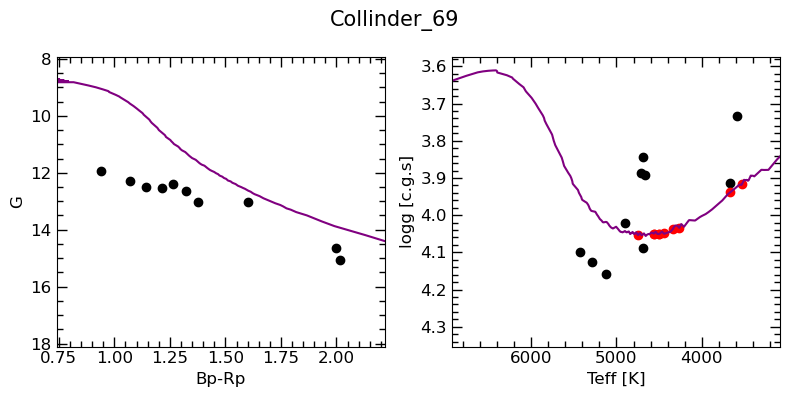

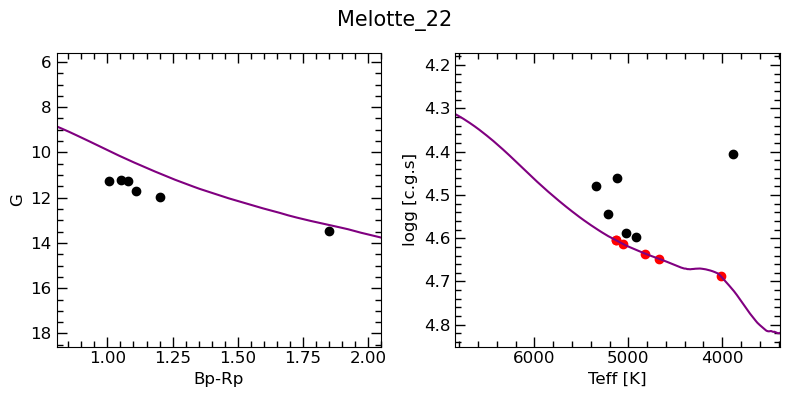

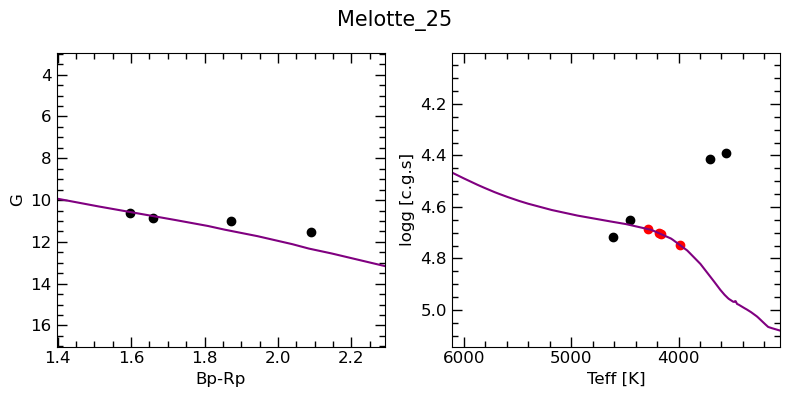

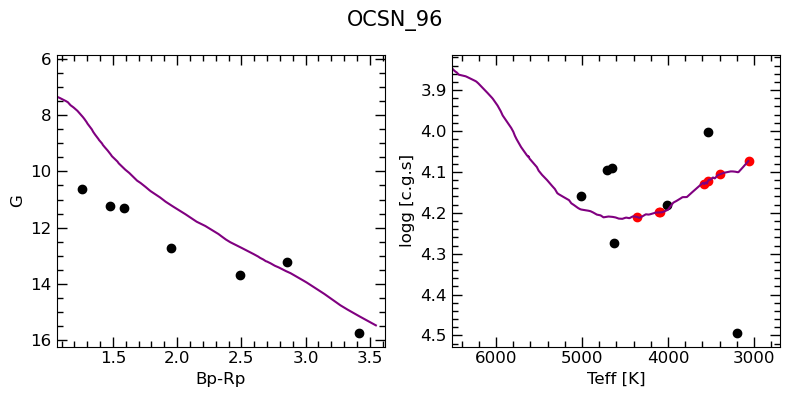

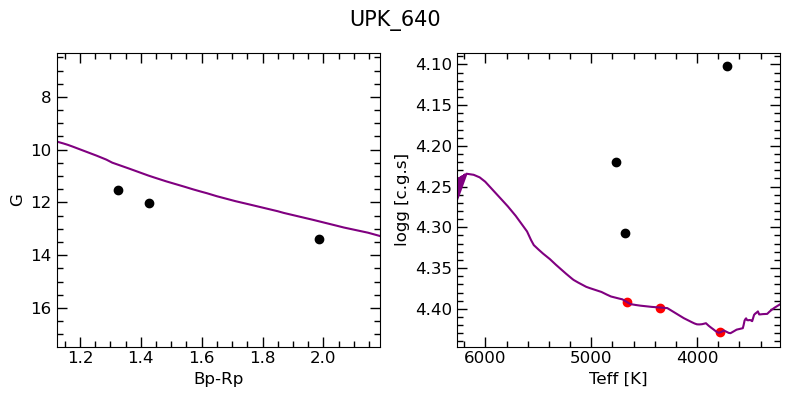

In [16]:
cluster_names = np.unique(members['cluster'])

for i in cluster_names:
    cluster = members[members['cluster']==i]

    cparams = cantello_parameters[cantello_parameters['Cluster']==i]
    N = 1000
    masses = FlatPrior((0.1,3)).sample(N)
    feh = cparams['[Fe/H]50']
    age = cparams['logAge50']  # 6 Gyr
    distance = cparams['dist50']  # 8 kpc
    AV = cparams['AV50']

    tracks = get_ichrone('mist', tracks=True)
    df = tracks.generate(masses, age, feh, distance=distance, AV=AV)
    df = df.sort_values(by=['G_mag'])
    
    fig,ax = plt.subplots(1,2,figsize=(8,4))
    plt.suptitle(i,fontsize=15)

    ax[0].plot(df['BP_mag'] - df['RP_mag'], df['G_mag'],c='purple')
    ax[0].scatter(cluster['bp_rp'], cluster['phot_g_mean_mag'],c='black')
    ax[0].set_xlim(np.nanmin(cluster['bp_rp'])-0.2,np.nanmax(cluster['bp_rp'])+0.2)
    ax[0].invert_yaxis()
    ax[0].minorticks_on()
    ax[0].tick_params(which='minor', direction='in', right='on', top='on',length=4, width = 1.0)
    ax[0].tick_params(which='major', direction='in', labelsize=12, right='on',top='on', length=7, width = 1.0)
    ax[0].set_xlabel('Bp-Rp',fontsize=12)
    ax[0].set_ylabel('G',fontsize=12)
    

    ax[1].plot(df['Teff'], df['logg'],c='purple')
    ax[1].scatter(cluster['teff'], cluster['logg'],c='black')
    ax[1].scatter(cluster['iso_teff'], cluster['iso_logg'],c='red')
    ax[1].set_xlabel('Teff [K]',fontsize=12)
    ax[1].set_ylabel('logg [c.g.s]',fontsize=12)
    ax[1].set_xlim(np.nanmin(cluster['teff'])-500,np.nanmax(cluster['teff'])+1500)
    ax[1].invert_yaxis()
    ax[1].invert_xaxis()
    ax[1].minorticks_on()
    ax[1].tick_params(which='minor', direction='in', right='on', top='on',length=4, width = 1.0)
    ax[1].tick_params(which='major', direction='in', labelsize=12, right='on',top='on', length=7, width = 1.0)
    plt.tight_layout()
    plt.savefig('iso_fit_{}.pdf'.format(i))
    # ptl.scatter(clust)
    # print(np.nanmedian(cluster['fe_h']), np.nanstd(cluster['fe_h']))

In [17]:
# x = members.to_pandas()

# members = members[members['cluster']!='HSC_2907']


# cluster = members[members['cluster']=='Melotte_25']
# other = members[members['cluster']!='Melotte_25']

# cluster = cluster[cluster['iso_teff'] < 5400]

# members = vstack([cluster, other])
members

sobject_id,tmass_id,gaiadr3_source_id,survey_name,field_id,setup,mjd,ra,dec,flag_sp,flag_sp_fit,opt_loop,flag_red,snr_px_ccd1,snr_px_ccd2,snr_px_ccd3,snr_px_ccd4,chi2_sp,px_used_perc,model_name,closest_model,comp_time,fit_global_rv,rv_comp_1,e_rv_comp_1,rv_comp_2,e_rv_comp_2,rv_gaia_dr3,e_rv_gaia_dr3,v_bary_eff,teff,e_teff,logg,e_logg,fe_h,e_fe_h,flag_fe_h,vmic,e_vmic,vsini,e_vsini,nn_li_fe,nn_e_li_fe,nn_flag_li_fe,c_fe,e_c_fe,flag_c_fe,n_fe,e_n_fe,flag_n_fe,o_fe,e_o_fe,flag_o_fe,na_fe,e_na_fe,flag_na_fe,mg_fe,e_mg_fe,flag_mg_fe,al_fe,e_al_fe,flag_al_fe,si_fe,e_si_fe,flag_si_fe,k_fe,e_k_fe,flag_k_fe,ca_fe,e_ca_fe,flag_ca_fe,sc_fe,e_sc_fe,flag_sc_fe,ti_fe,e_ti_fe,flag_ti_fe,v_fe,e_v_fe,flag_v_fe,cr_fe,e_cr_fe,flag_cr_fe,mn_fe,e_mn_fe,flag_mn_fe,co_fe,e_co_fe,flag_co_fe,ni_fe,e_ni_fe,flag_ni_fe,cu_fe,e_cu_fe,flag_cu_fe,zn_fe,e_zn_fe,flag_zn_fe,rb_fe,e_rb_fe,flag_rb_fe,sr_fe,e_sr_fe,flag_sr_fe,y_fe,e_y_fe,flag_y_fe,zr_fe,e_zr_fe,flag_zr_fe,mo_fe,e_mo_fe,flag_mo_fe,ru_fe,e_ru_fe,flag_ru_fe,ba_fe,e_ba_fe,flag_ba_fe,la_fe,e_la_fe,flag_la_fe,ce_fe,e_ce_fe,flag_ce_fe,nd_fe,e_nd_fe,flag_nd_fe,sm_fe,e_sm_fe,flag_sm_fe,eu_fe,e_eu_fe,flag_eu_fe,mass,age,bc_ks,a_ks,lbol,r_med,r_lo,r_hi,sb2_rv_16,sb2_rv_50,sb2_rv_84,ew_h_beta,ew_h_alpha,res_h_beta,res_h_alpha,ew_k_is,sigma_k_is,rv_k_is,ew_dib5780,sigma_dib5780,rv_dib5780,ew_dib5797,sigma_dib5797,rv_dib5797,ew_dib6613,sigma_dib6613,rv_dib6613,ebv,phot_g_mean_mag,bp_rp,j_m,j_msigcom,h_m,h_msigcom,ks_m,ks_msigcom,W2mag,e_W2mag,ruwe,parallax,parallax_error,ew_li,e_ew_li_low,e_ew_li_upp,a_li,a_li_upp_lim,e_a_li_low,e_a_li_upp,e_a_li_teff,flag_a_li,cluster,prob,pmra,pmde,plx,Gmag,BPmag,RPmag,closest_eep,phot_distance,eep,iso_age,iso_radius,iso_teff,iso_logg,iso_feh,iso_mass
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,,mas,mas,,,,,,,,,,,,mas / yr,mas / yr,mas,mag,mag,mag,,,,,,,,,
int64,bytes17,int64,bytes17,int32,bytes7,float32,float64,float64,int32,int32,int32,int32,float32,float32,float32,float32,float32,int64,bytes16,bytes16,float32,bool,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bytes20,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
181225002101151,04052565+1926316,50298125783225088,k2_hermes,6587,allstar,58477.47,61.356956481933594,19.442138671875,2,8,2,0,64.57906,120.23844,180.69221,--,2.602075,94,4500_4.50_-0.50,4500_4.50_-0.50,144.26091,True,37.899845,0.17064632,--,--,37.686657,0.23289202,-15.234427452087402,4612.912,66.9447,4.7155704,0.10605261,-0.3307236,0.055260316,0,0.5439809,0.28227153,6.2881956,1.4602691,-0.020175284,0.031979833,0,0.16416515,0.01793757,32,--,--,34,--,--,2,0.14191812,0.00746792

In [18]:
# x.to_csv('galah_members_isochrone_parameters.csv')

In [19]:
members.write('galah_members_isochrone_parameters.fits',overwrite=True)

In [20]:
sobject_ids = list(members['sobject_id'])

In [21]:
string = ''
for i in sobject_ids:
    string = string + str(i) + ','
string

'181225002101151,151008004001047,170117002101072,170130001601354,150109001001045,150109001001186,150109001001355,150109001001254,150109001001278,150109001001175,190224002101222,190205001601103,190205001601126,190205001601071,190205001601042,190205001601165,190205001601018,190205001601399,190205001601083,190205001601068,150413005601075,150429003601252,140610004401001,140609002101390,140608003101141,140608003101024,210421006401233,220706001901266,220706001901188,210421008001176,'